In [1]:
import glob
import pandas as pd
catp = glob.glob("train/train/cat.*.*")
dogp = glob.glob("train/train/dog.*.*")
catt = [0] * len(catp)
dogt = [1] * len(dogp)
df = pd.DataFrame({
    "path":catp + dogp,
    "target":catt + dogt
})
df

,path,target
0,train/train\cat.0.jpg,0
1,train/train\cat.1.jpg,0
2,train/train\cat.10.jpg,0
3,train/train\cat.100.jpg,0
4,train/train\cat.1000.jpg,0
...,...,...
24995,train/train\dog.9995.jpg,1
24996,train/train\dog.9996.jpg,1
24997,train/train\dog.9997.jpg,1
24998,train/train\dog.9998.jpg,1


In [17]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import BatchNormalization
# 如果你要設置trainable與否, 一定要compile前
# CNN
for l in vgg.layers:
    l.trainable = False
# Normalize
x = BatchNormalization()(vgg.output)
# MLP
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(2, activation="softmax")(x)
model = Model(inputs=vgg.input, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [4]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [5]:
# 進到機器學習以後, 最好不要再出現pandas, 全部轉換nparray
import numpy as np
from sklearn.model_selection import train_test_split
x = np.array(df["path"])
y = np.array(df["target"])
result = train_test_split(x, y, test_size=0.1)
x_train, x_test, y_train, y_test = result

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(22500,)
(22500,)
(2500,)
(2500,)


In [7]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input
def get_images(x, y, batch):
    idx = np.random.randint(0, x.shape[0], batch)
    paths = x[idx]
    
    ori_img_list = []
    img_list = []
    for p in paths:
        img = load_img(p, target_size=(224, 224)).convert("RGB")
        img = np.array(img)
        img_pre = preprocess_input(img.astype("float64"))
        ori_img_list.append(img)
        img_list.append(img_pre)
    return (np.array(ori_img_list), 
            np.array(img_list), 
            np.array(y[idx]))
        
ori, pre, target = get_images(x_train, y_train, 20)
print(ori.shape)
print(pre.shape)
print(target.shape)
# print(pre)

(20, 224, 224, 3)
(20, 224, 224, 3)
(20,)


In [15]:
TRAIN_BATCH = 20
VALIDATE_BATCH = 20

for i in range(10):
    print("-" * 15, "Epoch:", i, "-" * 15)
    _, imgs, targets = get_images(x_train, y_train, TRAIN_BATCH)
    train_result = model.train_on_batch(imgs, targets)
    print("[Train]:", train_result)
    _, imgs, targets = get_images(x_test, y_test, VALIDATE_BATCH)
    test_result = model.test_on_batch(imgs, targets)
    print("[Test]:", test_result)

--------------- Epoch: 0 ---------------
[Train]: [0.6476873, 0.92727274]
[Test]: [9.7955475, 0.75]
--------------- Epoch: 1 ---------------
[Train]: [1.7858136, 0.9]
[Test]: [4.6751695, 0.85]
--------------- Epoch: 2 ---------------
[Train]: [0.0062394342, 1.0]
[Test]: [1.5344771, 0.9]
--------------- Epoch: 3 ---------------
[Train]: [0.37113756, 0.95]
[Test]: [3.7720428, 0.8]
--------------- Epoch: 4 ---------------
[Train]: [2.048857e-05, 1.0]
[Test]: [4.10369, 0.9]
--------------- Epoch: 5 ---------------
[Train]: [0.32235643, 0.95]
[Test]: [1.549337, 0.85]
--------------- Epoch: 6 ---------------
[Train]: [5.0033315e-05, 1.0]
[Test]: [1.286078, 0.85]
--------------- Epoch: 7 ---------------
[Train]: [0.26969475, 0.95]
[Test]: [2.7790003, 0.9]
--------------- Epoch: 8 ---------------
[Train]: [0.016175557, 1.0]
[Test]: [0.59411067, 0.9]
--------------- Epoch: 9 ---------------
[Train]: [2.8498008, 0.95]
[Test]: [4.0587034, 0.9]


In [13]:
model.predict(imgs)

array([[9.9999964e-01, 3.8213972e-07],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 2.5160094e-19],
       [0.0000000e+00, 1.0000000e+00],
       [3.0228963e-32, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.5547915e-11],
       [1.7628848e-38, 1.0000000e+00],
       [1.0000000e+00, 3.4958667e-26],
       [7.0636718e-35, 1.0000000e+00],
       [1.0000000e+00, 3.1441550e-24],
       [1.5196321e-08, 1.0000000e+00],
       [1.0000000e+00, 3.2833104e-19],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [18]:
testori, testimg, testtarget = get_images(x_test, y_test, 200)
model.evaluate(testimg, testtarget)

200/200 [==============================] - 57s 285ms/step


[1.9228656387329102, 0.8849999904632568]

In [19]:
# Model跟Sequential不一樣, 他沒有predict_classes
# predict + argmax(找到最大值的索引)來把它變成是類別
pre = model.predict(testimg)
pre

array([[4.95968135e-37, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 6.32695975e-19],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 9.30924853e-34],
       [1.40316225e-14, 1.00000000e+00],
       [8.29176456e-02, 9.17082310e-01],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 2.87793056e-23],
       [1.00000000e+00, 6.03784478e-28],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.55119738e-35],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 9.30924853e-34],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 3.34537483e-26],
       [1.00000000e+00, 4.21432908e-14],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [5.70497783e-18, 1.00000000e+00],
       [0.000000

In [20]:
pre = pre.argmax(axis=1)
pre

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1], dtype=int64)

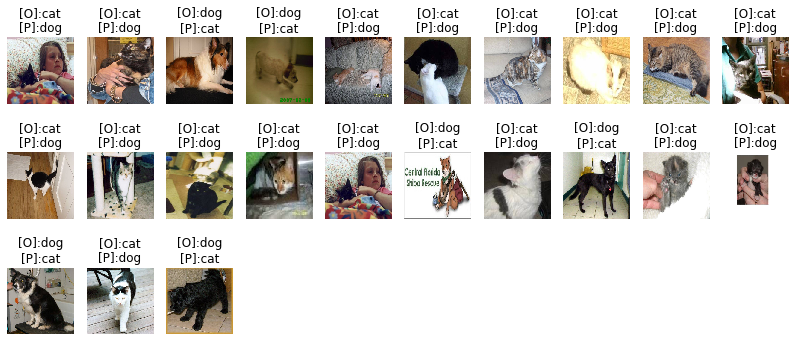

In [23]:
import matplotlib.pyplot as plt
trans = ["cat", "dog"]
# np: !=來比較每個位置的相等
# nonzero: 找到所有不為0的位置
# [類似list] -> 把所有東西一次拿給你
idx = np.nonzero(pre != testtarget)[0]

false_label = testtarget[idx]
false_pre = pre[idx]
false_img = testori[idx]

width = 10
height = len(idx) // width + 1
plt.figure(figsize=(14, 6))

false_collection = zip(false_label, false_pre, false_img)
# 得到每一個: (index, (false_label, pre, img))
for i, (l, p, img) in enumerate(false_collection):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[l], trans[p])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)